## Is there a relationship between the number of times a user tweeted and the sentiment of their tweets?

In [3]:
%matplotlib inline
from sklearn.cross_validation import train_test_split
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from __future__ import division
from collections import Counter
import pandas as pd
import numpy as np
import string
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
# Read in tweet data
tweets_data_path = 'Tweets.csv'
tweets = pd.read_csv(tweets_data_path, header=0, parse_dates=['tweet_created'])

Create a subset of tweets containing only tweets by the 50 users who had the most tweets during the time period the data spans.

In [5]:
how_many_tweeters = 50
tweets= tweets[tweets.name != 'JetBlueNews']

most_freq_tweeters = tweets.groupby('name').size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'}).iloc[0:how_many_tweeters, :]
tweets_by_most_freq_tweeters = tweets[tweets.name.isin(most_freq_tweeters.name)]

tweets_by_most_freq_tweeters.shape

(816, 15)

Calculate proportion of tweets that were of a given sentiment -- both for all the tweets and tweets by only the most prolific tweeters.

In [6]:
most_freq_sent = pd.DataFrame(tweets_by_most_freq_tweeters.airline_sentiment.value_counts() / tweets_by_most_freq_tweeters.shape[0]).reset_index()
all_sent = pd.DataFrame(tweets.airline_sentiment.value_counts() / tweets.shape[0]).reset_index()
all_sent['users'] = 'all'
most_freq_sent['users'] = 'most_freq'
sent_df = pd.concat([all_sent, most_freq_sent]).rename(columns={'index': 'sentiment', 'airline_sentiment': 'percentage'})
sent_df

,sentiment,percentage,users
0,negative,0.630,all
1,neutral,0.209,all
2,positive,0.162,all
0,negative,0.744,most_freq
1,neutral,0.192,most_freq
2,positive,0.064,most_freq


The graph below suggests that the tweets by the most prolific tweeters were more likely to be negative and less likely to be positive.

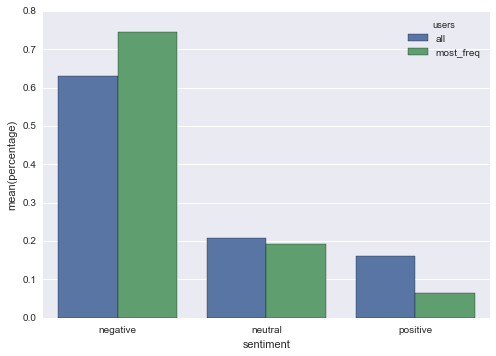

In [7]:
sns.barplot(data=sent_df, x='sentiment', y='percentage', hue='users')

Create a column in the tweets df containing the total number of tweets made by the user who made that particular tweet. Also, label encode the airline sentiment column.

In [8]:
from sklearn import preprocessing

num_tweets_per_user = pd.DataFrame(tweets.name.value_counts()).rename(columns={'name': 'num_of_tweets_by_user'})
tweets = tweets.merge(num_tweets_per_user, left_on='name', right_index=True)

le = preprocessing.LabelEncoder()
le.fit(['negative', 'neutral', 'positive'])
tweets['sentiment_encoded'] = le.transform(tweets.airline_sentiment.values)
tweets_by_most_freq_tweeters['sentiment_encoded'] = le.transform(tweets_by_most_freq_tweeters.airline_sentiment.values)
tweets[['airline_sentiment', 'sentiment_encoded', 'num_of_tweets_by_user']].head()

,airline_sentiment,sentiment_encoded,num_of_tweets_by_user
0,neutral,1,1
1,positive,2,4
3,negative,0,4
4,negative,0,4
5,negative,0,4


It seems that the more a user tweets, the more likely their tweets are to be negative.

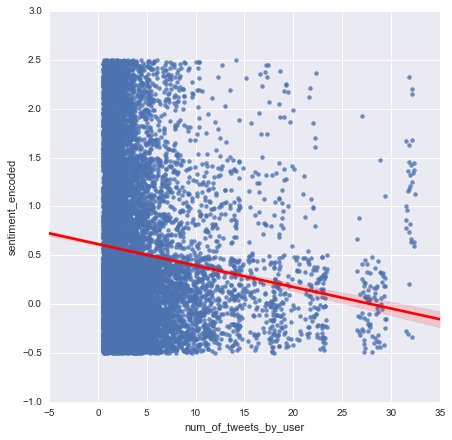

In [16]:
plt.figure(figsize=(7,7))
sns.regplot(data=tweets, x='num_of_tweets_by_user', y='sentiment_encoded', line_kws={'color': 'red'}, x_jitter= 0.5, y_jitter=0.5)

Let's look at problem another way by calculating the number of tweets by each user and the mean sentiment of all their tweets.

In [10]:
user_sent_mean = tweets.groupby('name')['sentiment_encoded'].mean().reset_index().rename(columns={'sentiment_encoded':'mean_sent', 'index':'name'})
num_tweet_mean_sent = pd.merge(num_tweets_per_user, user_sent_mean, right_on='name', left_index=True)
num_tweet_mean_sent.head()

,num_of_tweets_by_user,name,mean_sent
5628,32,kbosspotter,1.062
3516,29,_mhertz,0.069
6493,28,otisday,0.000
7357,27,throthra,0.148
7592,23,weezerandburnie,0.000


Like the graph above, we see a negative relationship between tweet sentiment and the number of tweets by a user.

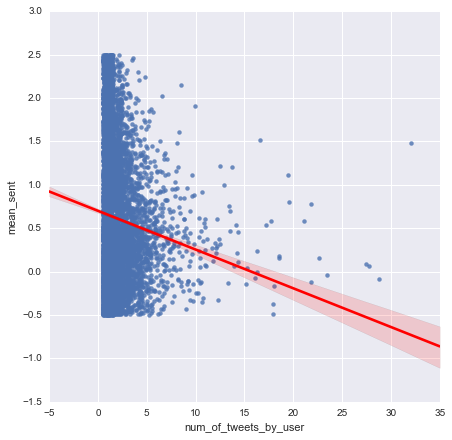

In [19]:
plt.figure(figsize=(7,7))
sns.regplot(data=num_tweet_mean_sent, x='num_of_tweets_by_user', y='mean_sent',  line_kws={'color': 'red'}, x_jitter= 0.5, y_jitter=0.5)

Run a t-test comparing the tweet sentiment of the most prolific tweeters to the rest of the tweeters. The result is significant, but is the test valid?

In [12]:
from scipy.stats import ttest_ind_from_stats
tweets_not_by_most_freq = tweets[~tweets.isin(tweets_by_most_freq_tweeters)].dropna(how = 'all')

t, p = ttest_ind_from_stats(mean1=tweets_by_most_freq_tweeters.sentiment_encoded.mean() , 
          std1=tweets_by_most_freq_tweeters.sentiment_encoded.std(), 
          nobs1= tweets_by_most_freq_tweeters.sentiment_encoded.shape[0], 
          mean2 = tweets_not_by_most_freq.sentiment_encoded.mean(), 
          std2= tweets_not_by_most_freq.sentiment_encoded.std(), 
          nobs2 = tweets_not_by_most_freq.sentiment_encoded.shape[0], 
          equal_var=False)
print('T-Statistic: {:.3f}, P-Value: {:.3f}'.format(t, p))

T-Statistic: -10.451, P-Value: 0.000


Below, we fit a logistic regression model predicting a tweet's sentiment given by the number of tweets written by its author during the month. The coefficients indicate that the more a tweet's author has tweeted during the month, the more negative it's likely to be. 

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(tweets.num_of_tweets_by_user.values.reshape(-1, 1), tweets.sentiment_encoded)
coefficients = lr.coef_.ravel()
print('negative coefficient: {:.2f}, neutral coefficient: {:.2f}, positive coefficient: {:.2f}'.format(
        coefficients[0], 
        coefficients[1], 
        coefficients[2]))


negative coefficient: 0.06, neutral coefficient: -0.02, positive coefficient: -0.12
